In [1]:
#Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Import your local modules
from models.neural_net import PINN
from data.data_generator import load_normalized_data
from utils import plot_prediction_surface, compute_rmse
from config import config

# Import training main
from main_train import main as train_model



Training the model using main()
Starting PINN Training Pipeline
🔧 Using device: cpu
Loading dataset...
Initializing PINN model...
Starting training loop...
Epoch 0: Total Loss = 179110656.000000 | Supervised Loss = 179110656.000000 | Residual Loss = 0.006109
Epoch 500: Total Loss = 178339936.000000 | Supervised Loss = 178339936.000000 | Residual Loss = 0.000026
Epoch 1000: Total Loss = 177680576.000000 | Supervised Loss = 177680576.000000 | Residual Loss = 0.000003
Epoch 1500: Total Loss = 177028032.000000 | Supervised Loss = 177028032.000000 | Residual Loss = 0.000001
Epoch 2000: Total Loss = 176379632.000000 | Supervised Loss = 176379632.000000 | Residual Loss = 0.000000
Epoch 2500: Total Loss = 175734416.000000 | Supervised Loss = 175734416.000000 | Residual Loss = 0.000000
Epoch 3000: Total Loss = 175092000.000000 | Supervised Loss = 175092000.000000 | Residual Loss = 0.000000
Epoch 3500: Total Loss = 174452144.000000 | Supervised Loss = 174452144.000000 | Residual Loss = 0.000000


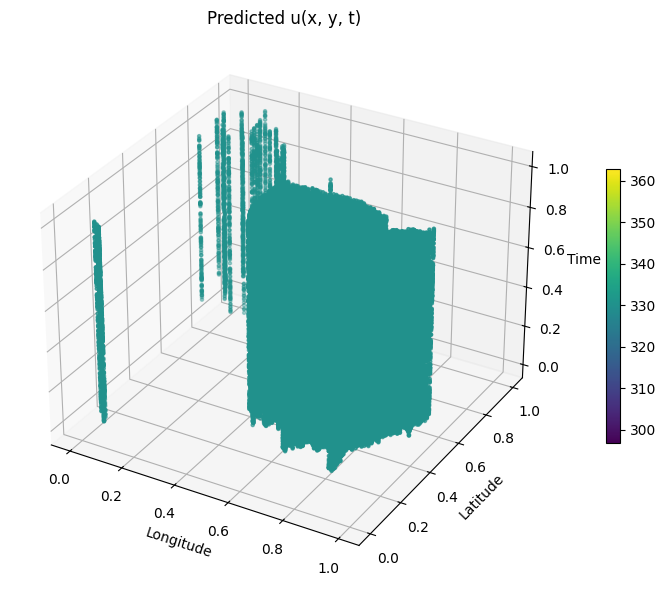

Model saved to: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth


In [2]:
#Train the model from scratch and save it
print("Training the model using main()")
train_model()


**We load the trained PINN model using the architecture defined in neural_net.py. This allows evaluation on unseen test points.**

In [3]:
# Load trained model
print("Loading trained model...")
device = torch.device(config["device"])

model = PINN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    hidden_layers=config["hidden_layers"],
    output_dim=config["output_dim"]
).to(device)

checkpoint_path = config["checkpoint_path"]
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Model loaded from: {checkpoint_path}")


Loading trained model...
Model loaded from: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth


In [4]:
# Load test data
_, _, _, X_test, u_test = load_normalized_data(config["data_path"],
                                               n_collocation=config["n_collocation"],
                                               split_ratio=config["train_test_split"],
                                               device=device)

# Predict and compute RMSE
with torch.no_grad():
    u_pred = model(X_test)
    rmse = compute_rmse(u_pred, u_test, apply_expm1=True)
    print(f"RMSE on test set: {rmse:.6f}")


RMSE on test set: 13118.963468


**We compute RMSE to measure the model's generalization error on unseen spatiotemporal points**

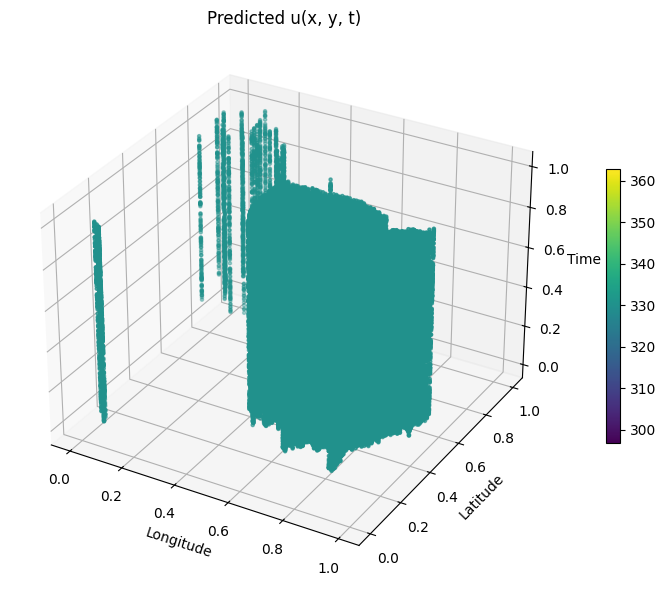

In [5]:
# Visualize surface plot
plot_prediction_surface(X_test, u_pred, title="Predicted u(x, y, t)")

**This surface plot visualizes the predicted values of the normalized case count across 3D input space (lon, lat, time)**

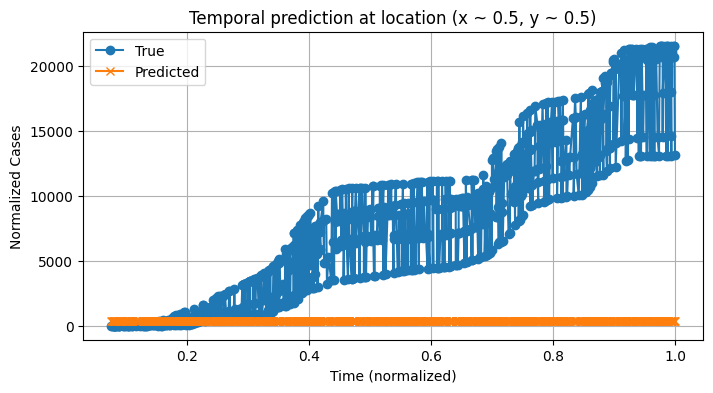

In [6]:
# Convert tensors to NumPy
X_test_np = X_test.cpu().numpy()
u_test_np = u_test.cpu().numpy()
u_pred_np = u_pred.cpu().numpy()

# Pick a location (x, y) close to [0.5, 0.5]
mask = np.abs(X_test_np[:, 0] - 0.5) < 0.01  # lon ~ 0.5
mask &= np.abs(X_test_np[:, 1] - 0.5) < 0.01  # lat ~ 0.5

x_slice = X_test_np[mask]
u_true_slice = u_test_np[mask]
u_pred_slice = u_pred_np[mask]

if len(x_slice) > 0:
    idx = np.argsort(x_slice[:, 2])  # sort by time
    plt.figure(figsize=(8, 4))
    plt.plot(x_slice[idx, 2], u_true_slice[idx], label="True", marker='o')
    plt.plot(x_slice[idx, 2], u_pred_slice[idx], label="Predicted", marker='x')
    plt.xlabel("Time (normalized)")
    plt.ylabel("Normalized Cases")
    plt.title("Temporal prediction at location (x ~ 0.5, y ~ 0.5)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No points found near (0.5, 0.5). Try adjusting location mask.")


**Here we visualize the predicted time evolution of COVID-19 cases at a fixed location to evaluate dynamic consistency**